# Part B: Customer Segmentation

- Name : Tan Yu Hoe
- Admin No : P2026309
- Class : DAAA/FT/2A/04


# Problem Statement

As the owner of the mall and you want to understand your customers so that appriopriate directions can be given to the marketing team for them plan their strategy accordingly.

By the end of this case study, you would be able to answer below questions.

- How to achieve customer segmentation using unsupervised learning machine learning algorithm in Python?
- Who are your target customers with whom you can start marketing strategy?

In [18]:
# import libraries/packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
plt.rcParams.update({
    'figure.figsize': (16, 8)
})
import warnings

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

## <h2>Metadata</h2>

| Attribute | Description | Type |
|---|---|---|
| CustomerID | customer identifier key | Discrete |
| Gender | Customer's gender | Nominal |
| Age | Customer's age | Continuous |
| Annual Income (k$) | Customer's annual income denominated in thousands | Continuous |
| Spending Score (1-100) | spending score between 1 to 100 | Continuous |

<link href='styles.css' rel='stylesheet'>
<!--bootstrap-->
<link href="https://cdn.jsdelivr.net/npm/bootstrap@5.0.2/dist/css/bootstrap.min.css" rel="stylesheet" integrity="sha384-EVSTQN3/azprG1Anm3QDgpJLIm9Nao0Yz1ztcQTwFspd3yD65VohhpuuCOmLASjC" crossorigin="anonymous">

In [20]:
# reading customer .csv file
customers = pd.read_csv('./assets/unsupervised/Mall_Customers.csv', index_col='CustomerID')
customers.rename(columns={'Annual Income (k$)': 'Annual Income', 'Spending Score (1-100)': 'Spending Score'}, inplace=True)
customers_index = customers.index
display(customers, customers_index)

Gender  Age  Annual Income  Spending Score
CustomerID                                            
1             Male   19             15              39
2             Male   21             15              81
3           Female   20             16               6
4           Female   23             16              77
5           Female   31             17              40
...            ...  ...            ...             ...
196         Female   35            120              79
197         Female   45            126              28
198           Male   32            126              74
199           Male   32            137              18
200           Male   30            137              83

[200 rows x 4 columns]

Int64Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
            ...
            191, 192, 193, 194, 195, 196, 197, 198, 199, 200],
           dtype='int64', name='CustomerID', length=200)

In [21]:
# summary of the dataset
customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Gender          200 non-null    object
 1   Age             200 non-null    int64 
 2   Annual Income   200 non-null    int64 
 3   Spending Score  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB


- 200 rows and 4 columns
- all columns are numerical, except for gender
- memory usage is about 7.8KB, the dataset relatively small

# Exploratory Data Analysis

The problem statement requires us to use a clustering algorithm to perform customer segmentation. As such, exploring the data is an important step while attempting this case study as it gives us a better understanding of the dataset.


## Univariate Analysis

<p style="text-align:justify;text-justify:inter-word;">The objective for Univariate Analysis is to explore each variable in a dataset. This process involves exploring the descriptive and inferential statistics of each variables, such as central tendency and distribution</p>

In [22]:
# listing down continuous columns
continuous = ['Age', 'Annual Income', 'Spending Score']
# descriptive statistics
customers.describe(include='all').T

count unique     top freq   mean      std  min    25%   50%  \
Gender           200      2  Female  112    NaN      NaN  NaN    NaN   NaN   
Age              200    NaN     NaN  NaN  38.85   13.969   18  28.75    36   
Annual Income    200    NaN     NaN  NaN  60.56  26.2647   15   41.5  61.5   
Spending Score   200    NaN     NaN  NaN   50.2  25.8235    1  34.75    50   

                75%  max  
Gender          NaN  NaN  
Age              49   70  
Annual Income    78  137  
Spending Score   73   99

- the columns seems to be in similar magnitude, based on the mean and standard deviation
- have to use a boxplot to check whether feature scaling is needed
- there are two classes under 'Gender'
- there are more female customers than male customers being surveyed

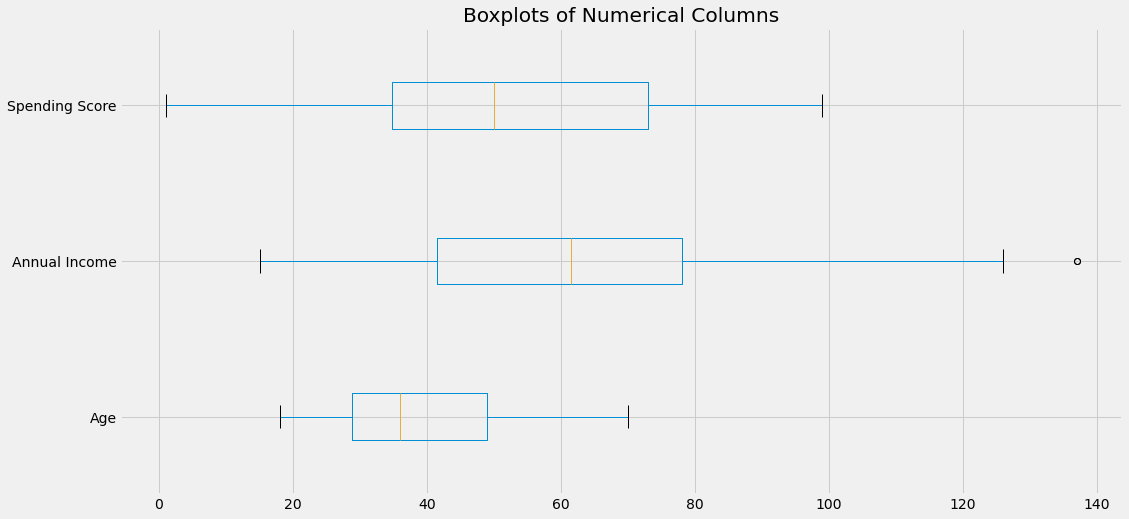

In [23]:
# boxplots of continuous columns
customers[continuous].plot.box(vert=False)
plt.title('Boxplots of Numerical Columns')
plt.show()

- all of the numerical columns seem to have similar scale, as there isn't any columns with extremely large values
- there is only one outlier in annual income, which doesn't seem to be too extreme

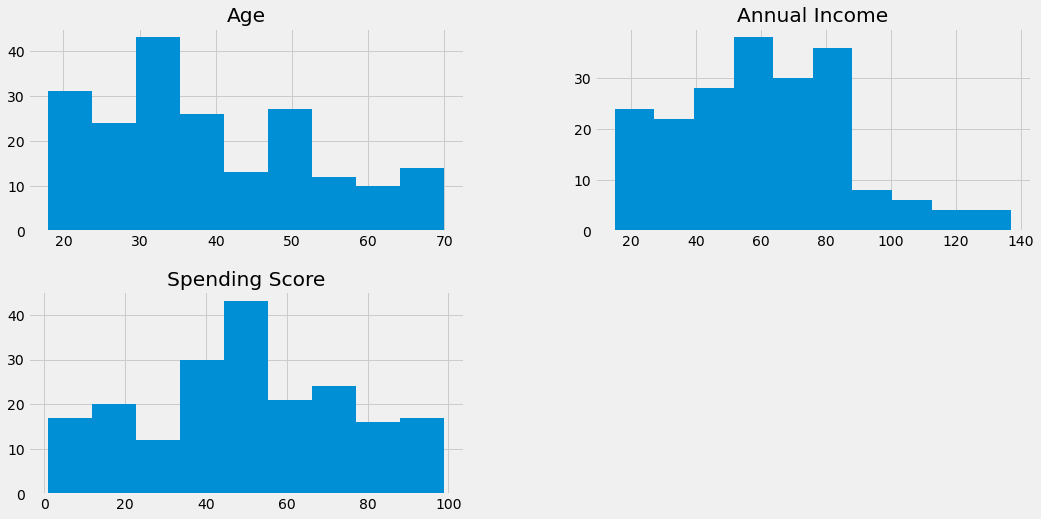

In [24]:
# distribution of numerical features
customers[continuous].hist(bins='auto')
plt.show()

- all of the numerical feature does not follow a normal or uniform distribution

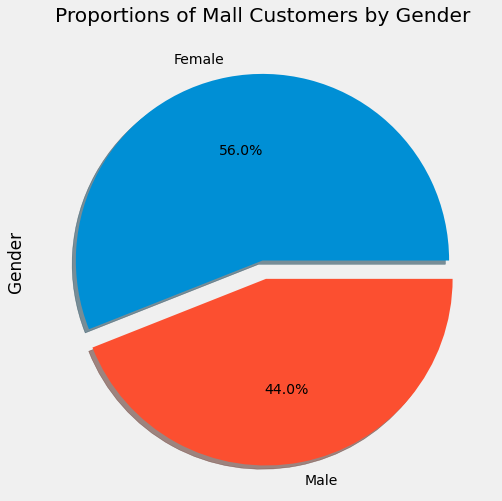

In [25]:
# pie chart on gender
customers['Gender'].value_counts().plot.pie(title="Proportions of Mall Customers by Gender", legend=False, autopct='%1.1f%%', explode=(0, 0.1), shadow=True, startangle=0)
plt.show()

- overall, there are more female customers compare to male customers
- the difference in margin is not so significant to consider the class to be imbalanced

## Bivariate Analysis

Bivariate Analysis refers to the analysis of two variables. The main goal is to analyse the relationship the two variables.

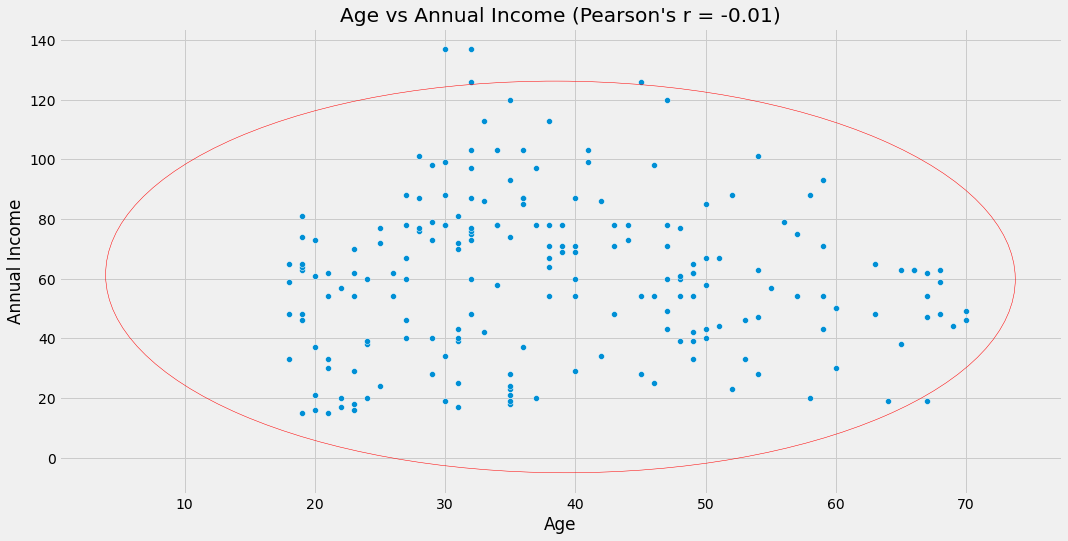

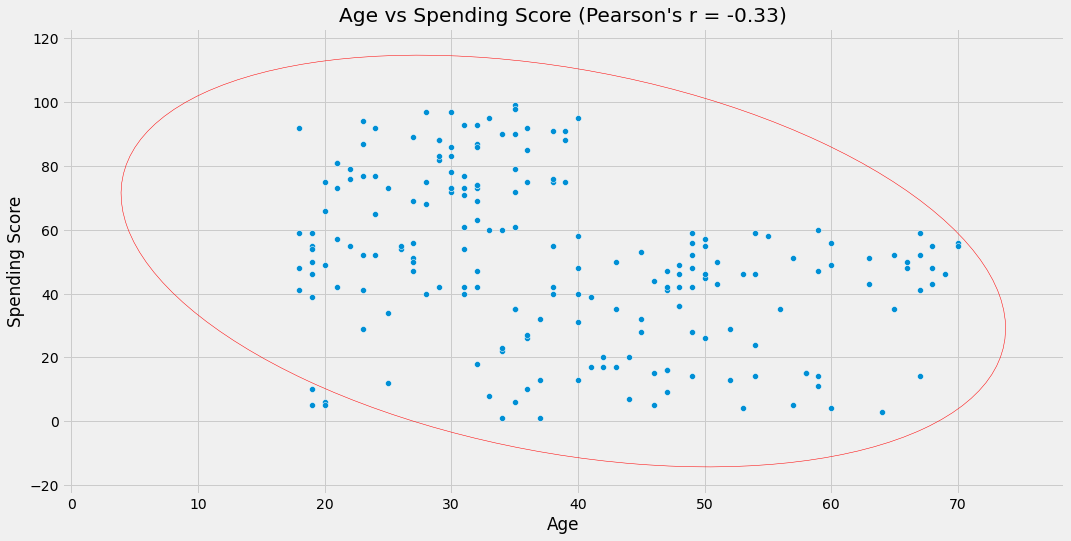

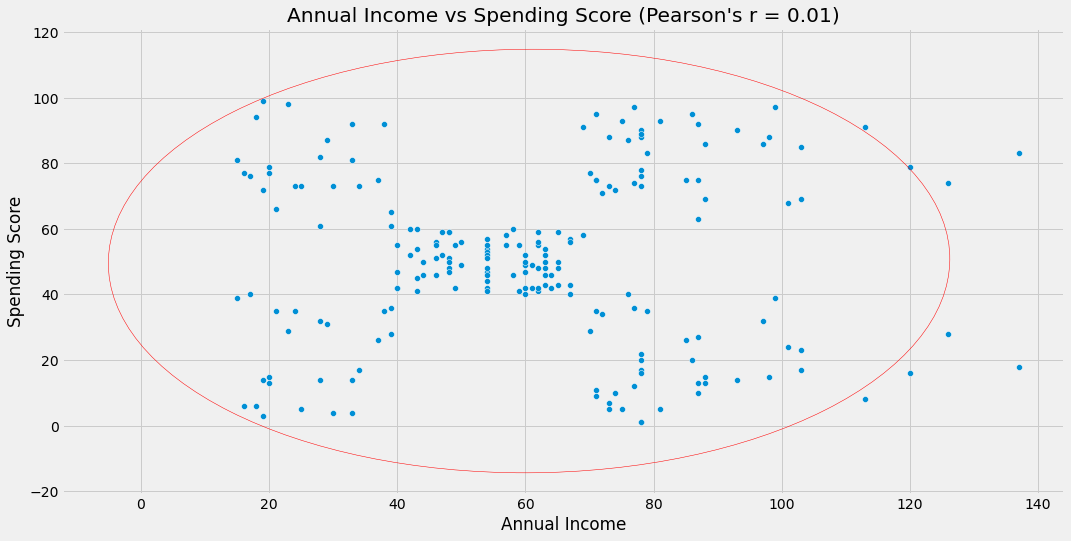

In [44]:
import itertools

# scatterplot of all paired combinations (w/o replacements) of numerical columns
for pair_1, pair_2 in list(itertools.combinations(continuous, 2)):
    fig, ax = plt.subplots()
    confidence_ellipse(x=customers[pair_1], y=customers[pair_2], ax=ax, edgecolor='red', n_std=2.5)
    sns.scatterplot(data=customers, x=pair_1, y=pair_2, ax=ax)
    plt.title(f"{pair_1} vs {pair_2} (Pearson's r = {np.corrcoef(customers[pair_1], customers[pair_2])[0,1]:.2f})")
    
    plt.show()

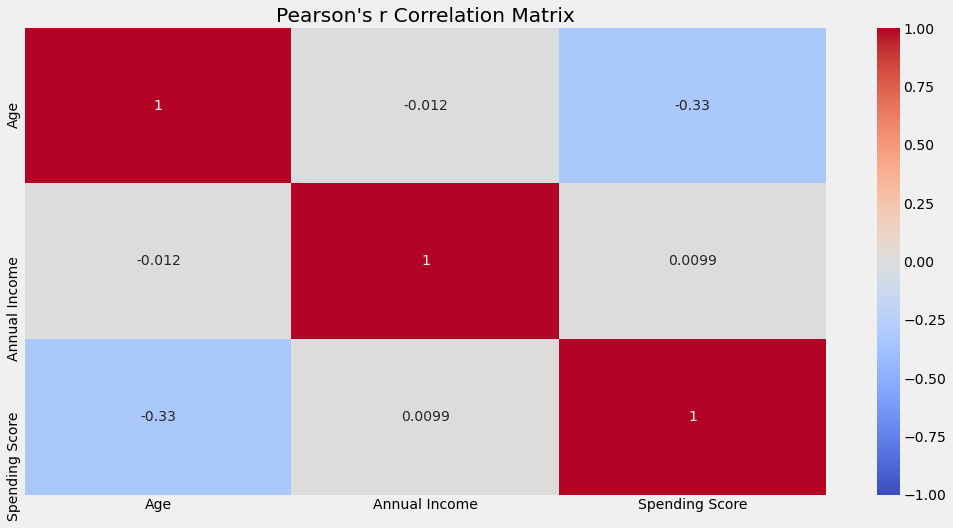

In [27]:
# pearson correlation matrix
sns.heatmap(data=customers.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Pearson's r Correlation Matrix")
plt.show()

## Multivariate Analysis

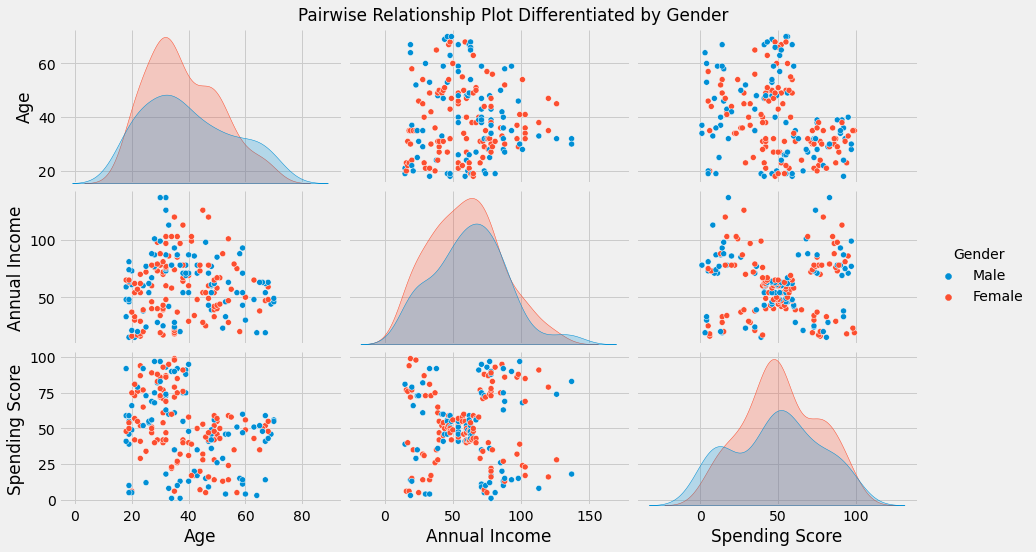

In [28]:
# pairwise relationship plot differentiated by gender
sns.pairplot(customers, hue='Gender', aspect=1.75).fig.suptitle('Pairwise Relationship Plot Differentiated by Gender', y=1.02)
plt.show()

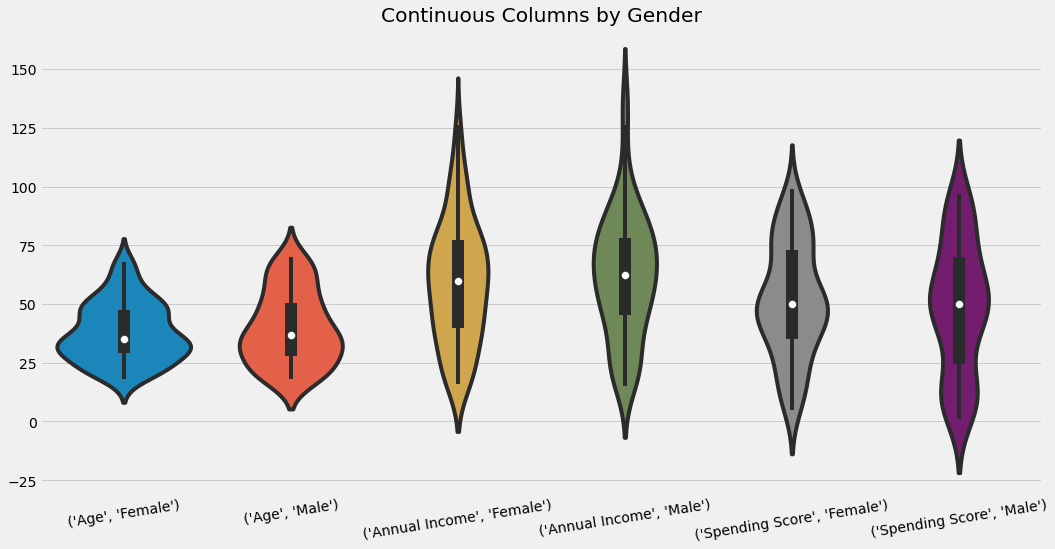

In [29]:
# Violinplot of Continuous Columns by Gender
sns.violinplot(data=customers.pivot(columns='Gender'))
plt.title('Continuous Columns by Gender')
plt.xticks(rotation=9)
plt.show()

In [30]:
# dropping Gender column
# customers.drop('Gender', axis=1, inplace=True, errors='ignore')
# display(customers)

### 2D Visualisation using t-SNE

Using t-SNE (t-distribution stochastic neigbor embedding), to visualise high dimensional data. Just a rough visualisation to roughly see clusters in the dataset.

Side-Note: t-SNE features are different everytime, however the relative position is the same.

In [31]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# One-Hot Encoding
ohe = ColumnTransformer(
    transformers=[
        ('OHE', OneHotEncoder(drop='first'), ['Gender'])
    ], remainder='passthrough'
)

# t-dsitrbuted stochastic neighbor embedding
tsne = TSNE(n_components=2, learning_rate=200)

# using dimension reduction tool to visualise the dataset on a 2-Dimension plane
eda_tsne = Pipeline(
    steps=[
        ('OHE', ohe),
        ('TSNE', tsne)
    ]
)

# storing embedding as a DataFrame
embedded_2d = pd.DataFrame(eda_tsne.fit_transform(customers), columns=['Component 1', 'Component 2'], index=customers_index)

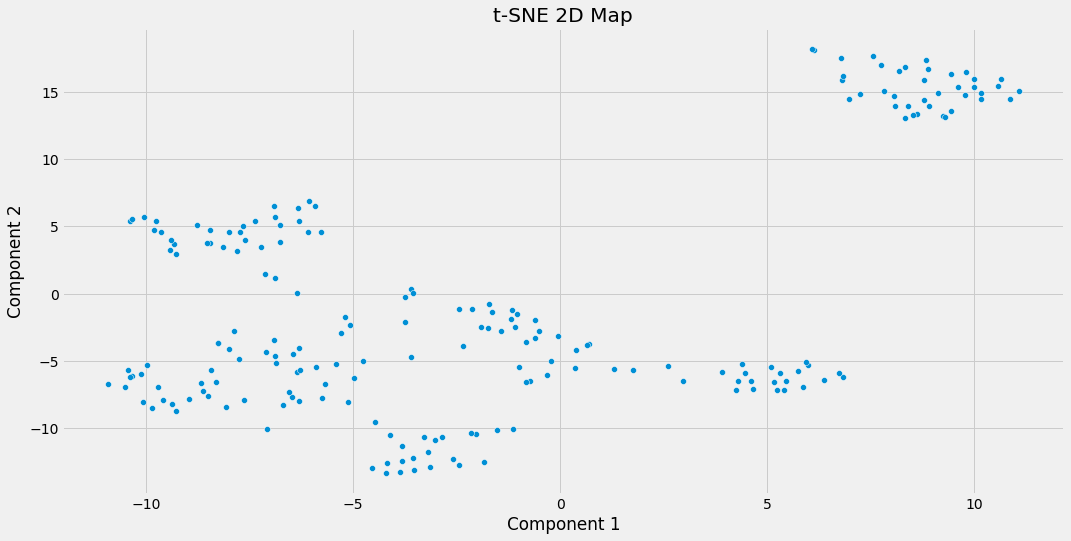

In [32]:
# t-SNE 2D map
sns.scatterplot(data=embedded_2d, x='Component 1', y='Component 2')
plt.title('t-SNE 2D Map')
plt.show()

# Preprocessing

- Encoding Gender
- Z-Score Standardisation

In [33]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# intialise one hot encoder instance
OHE = ColumnTransformer(
    transformers=[
        ('One-Hot Encoding', OneHotEncoder(sparse=False, drop='first'), ['Gender'])
    ], remainder='passthrough'
)

# creating preprocessing pipeline
preprocessing = Pipeline(
    steps=[
        ('OHE', OHE),
    ]
)

# transforming customers data
customers_transformed = pd.DataFrame(preprocessing.fit_transform(customers), columns=customers.columns).drop('Gender', axis=1)
display(customers_transformed)

Age  Annual Income  Spending Score
0    19.0           15.0            39.0
1    21.0           15.0            81.0
2    20.0           16.0             6.0
3    23.0           16.0            77.0
4    31.0           17.0            40.0
..    ...            ...             ...
195  35.0          120.0            79.0
196  45.0          126.0            28.0
197  32.0          126.0            74.0
198  32.0          137.0            18.0
199  30.0          137.0            83.0

[200 rows x 3 columns]

# <h1 style="background-color:orange;color:black;text-align:center;font-weight:600">KMeans</h1>



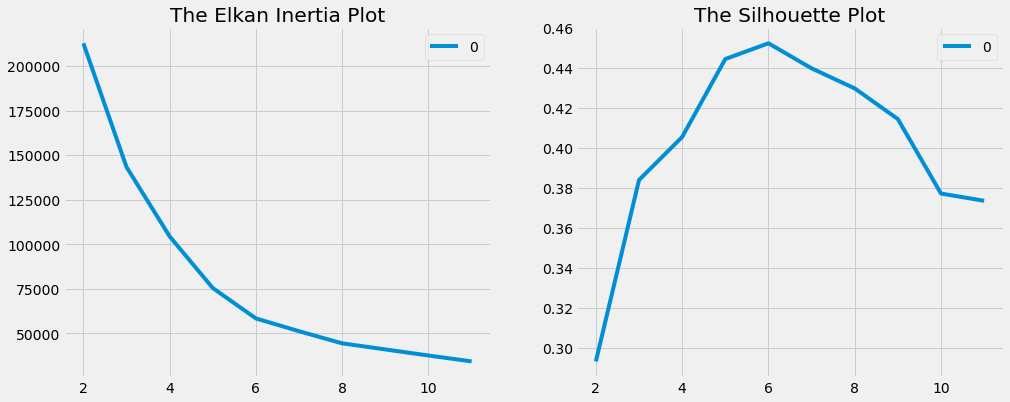

In [34]:
# Model Evaluation
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

inertia = []
silhouette = []
k_range = np.arange(2, 12)

for i in k_range:

    kmeans = KMeans(init='k-means++', algorithm='elkan', n_clusters=i, random_state=42)

    kmeans.fit(customers_transformed)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(customers_transformed, kmeans.labels_, metric='euclidean'))

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
pd.DataFrame(inertia, k_range).plot(ax=ax[0], title='The Elkan Inertia Plot')
pd.DataFrame(silhouette, k_range).plot(ax=ax[1], title='The Silhouette Plot')
plt.show()